In [251]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [252]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def modelfitx(alg, features, targets, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(features, targets)
    
    # Predict training set:
    dtrain_predictions = alg.predict(features)
    
    # Perform cross-validation if specified
    if performCV:
        from sklearn.model_selection import KFold, cross_val_score
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_score = cross_val_score(alg, features, targets, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Print model report:
    print("\nModel Report")
    print(f"Mean Squared Error : {mean_squared_error(targets, dtrain_predictions):.4g}")
    print(f"Mean Absolute Error : {mean_absolute_error(targets, dtrain_predictions):.4g}")
    
    if performCV:
        # Convert negative MSE scores to positive
        cv_score = -cv_score
        print(f"CV Score : Mean - {np.mean(cv_score):.4g} | Std - {np.std(cv_score):.4g} | Min - {np.min(cv_score):.4g} | Max - {np.max(cv_score):.4g}")
    
    # Print feature importance
    if printFeatureImportance:
        plt.figure(figsize=(12, 8))
        if hasattr(alg, 'feature_importances_'):
            feat_imp = pd.Series(alg.feature_importances_, index=features.columns).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
            plt.show()
        elif hasattr(alg, 'get_booster'):
            # For XGBRegressor
            import xgboost as xgb
            xgb.plot_importance(alg, max_num_features=20)
            plt.show()


In [253]:
df = pd.read_csv('match_w_conf.csv',low_memory=False)
df.reset_index(inplace=True)


df['FTR'] = df.apply(lambda row: 0 if row['homeScore'] > row['awayScore'] 
                     else (1 if row['awayScore'] > row['homeScore'] else 2), axis=1)

df['home_points'] = df['FTR'].apply(lambda x: 3 if x == 0 else (1 if x == 2 else 0))
df['away_points'] = df['FTR'].apply(lambda x: 3 if x == 1 else (1 if x == 2 else 0))




In [254]:
new_data = []
for index, row in df.iterrows():
    # Append home team and home score with is_home set to 1, along with additional stats
    new_data.append({
        'index': row['index'], 
        'is_home': 1, 
        'team': row['homeTeam'], 
        'score': row['homeScore'],
        'points': row['home_points'],
        'elo':row['homeElo'],
        'aggElo': row['homeAggElo'],
        'hc1':row['home_cluster_confidence_1'],
        'hc2':row['home_cluster_confidence_2'],
        'hc3':row['home_cluster_confidence_3'],
        'hc4':row['home_cluster_confidence_4'],
        'hc5':row['home_cluster_confidence_5'],
        'totalShotsOnGoal': row['hometotalShotsOnGoal'],
        'cornerKicks': row['homecornerKicks'],
        'fouls': row['homefouls'],
        'accuratePasses': row['homeaccuratePasses'],
        'yellowCards': row['homeyellowCards'],
        'offsides': row['homeoffsides'],
        'throwIns': row['homethrowIns'],
        'GoalsAgainst': row['awayScore'],  # Opposing team’s score as goals against
        'CornersAgainst': row['awaycornerKicks'],
        'FoulsAgainst': row['awayfouls'],
        'YellowCardsAgainst': row['awayyellowCards'],
        'ThrowInsAgainst': row['awaythrowIns'],
        'PassesAgainst': row['awayaccuratePasses'],
        'eloAgainst':row['awayElo'],
        'aggEloAgainst': row['awayAggElo']
        
    })
    
    # Append away team and away score with is_home set to 0, along with additional stats
    new_data.append({
        'index': row['index'], 
        'is_home': 0, 
        'team': row['awayTeam'], 
        'score': row['awayScore'],
        'points': row['away_points'],
        'aggElo': row['awayAggElo'],
        'ac1':row['cluster_confidence_1'],
        'ac2':row['cluster_confidence_2'],
        'ac3':row['cluster_confidence_3'],
        'ac4':row['cluster_confidence_4'],
        'ac5':row['cluster_confidence_5'],
        'elo': row['awayElo'],
        'totalShotsOnGoal': row['awaytotalShotsOnGoal'],
        'cornerKicks': row['awaycornerKicks'],
        'fouls': row['awayfouls'],
        'accuratePasses': row['awayaccuratePasses'],
        'yellowCards': row['awayyellowCards'],
        'offsides': row['awayoffsides'],
        'throwIns': row['awaythrowIns'],
        'GoalsAgainst': row['homeScore'],  # Opposing team’s score as goals against
        'CornersAgainst': row['homecornerKicks'],
        'FoulsAgainst': row['homefouls'],
        'YellowCardsAgainst': row['homeyellowCards'],
        'ThrowInsAgainst': row['homethrowIns'],
        'PassesAgainst': row['homeaccuratePasses'],
        'eloAgainst': row['homeElo'],
        'aggEloAgainst': row['homeAggElo']
    })

# Create the new DataFrame
df = pd.DataFrame(new_data)


In [255]:
# Sort by team and index to ensure the games are in the right order for each team
df = df.sort_values(by=['team', 'index'])

# Define the stats columns for which rolling averages are needed
stats_columns = [
    'score', 'totalShotsOnGoal', 'cornerKicks', 'fouls', 'accuratePasses', 
    'yellowCards', 'offsides', 'throwIns', 'GoalsAgainst', 'CornersAgainst', 
    'FoulsAgainst', 'YellowCardsAgainst', 'ThrowInsAgainst', 'PassesAgainst',
    'eloAgainst','aggEloAgainst','points'
]

# Calculate rolling averages for each stat with window sizes of 3, 5, and 7 games
for window in [3, 5, 7]:
    for stat in stats_columns:
        # Create a new column name for each rolling average (e.g., score_rolling_avg_3)
        rolling_column_name = f"{stat}_rolling_avg_{window}"
        
        # Calculate the rolling average and shift by 2 games (as per the previous request)
        df[rolling_column_name] = df.groupby('team')[stat].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))

# Display the DataFrame




In [256]:
import pandas as pd

# Separate home and away games and rename columns
home_games = df[df['is_home'] == 1].rename(columns={
    'team': 'hometeam',
    'score': 'homescore',
    'elo': 'homeElo',
    'aggElo': 'homeAggElo',
    'hc1':'hc1',
    'hc2':'hc2',
    'hc3':'hc3',
    'hc4':'hc4',
    'hc5':'hc5',
    'points_rolling_avg_3': 'home_points_rolling_avg_3',
    'score_rolling_avg_3': 'homescore_rolling_avg_3',
    'totalShotsOnGoal_rolling_avg_3': 'home_totalShotsOnGoal_rolling_avg_3',
    'cornerKicks_rolling_avg_3': 'home_cornerKicks_rolling_avg_3',
    'fouls_rolling_avg_3': 'home_fouls_rolling_avg_3',
    'accuratePasses_rolling_avg_3': 'home_accuratePasses_rolling_avg_3',
    'yellowCards_rolling_avg_3': 'home_yellowCards_rolling_avg_3',
    'offsides_rolling_avg_3': 'home_offsides_rolling_avg_3',
    'throwIns_rolling_avg_3': 'home_throwIns_rolling_avg_3',
    'GoalsAgainst_rolling_avg_3': 'home_GoalsAgainst_rolling_avg_3',
    'CornersAgainst_rolling_avg_3': 'home_CornersAgainst_rolling_avg_3',
    'FoulsAgainst_rolling_avg_3': 'home_FoulsAgainst_rolling_avg_3',
    'YellowCardsAgainst_rolling_avg_3': 'home_YellowCardsAgainst_rolling_avg_3',
    'ThrowInsAgainst_rolling_avg_3': 'home_ThrowInsAgainst_rolling_avg_3',
    'PassesAgainst_rolling_avg_3': 'home_PassesAgainst_rolling_avg_3',
    'eloAgainst_rolling_avg_3': 'home_eloAgainst_rolling_avg_3',
    'aggEloAgainst_rolling_avg_3': 'home_AggEloAgainst_rolling_avg_3',
    'score_rolling_avg_5': 'homescore_rolling_avg_5',
    'points_rolling_avg_5': 'home_points_rolling_avg_5',
    'totalShotsOnGoal_rolling_avg_5': 'home_totalShotsOnGoal_rolling_avg_5',
    'cornerKicks_rolling_avg_5': 'home_cornerKicks_rolling_avg_5',
    'fouls_rolling_avg_5': 'home_fouls_rolling_avg_5',
    'accuratePasses_rolling_avg_5': 'home_accuratePasses_rolling_avg_5',
    'yellowCards_rolling_avg_5': 'home_yellowCards_rolling_avg_5',
    'offsides_rolling_avg_5': 'home_offsides_rolling_avg_5',
    'throwIns_rolling_avg_5': 'home_throwIns_rolling_avg_5',
    'GoalsAgainst_rolling_avg_5': 'home_GoalsAgainst_rolling_avg_5',
    'CornersAgainst_rolling_avg_5': 'home_CornersAgainst_rolling_avg_5',
    'FoulsAgainst_rolling_avg_5': 'home_FoulsAgainst_rolling_avg_5',
    'YellowCardsAgainst_rolling_avg_5': 'home_YellowCardsAgainst_rolling_avg_5',
    'ThrowInsAgainst_rolling_avg_5': 'home_ThrowInsAgainst_rolling_avg_5',
    'PassesAgainst_rolling_avg_5': 'home_PassesAgainst_rolling_avg_5',
    'eloAgainst_rolling_avg_5': 'home_eloAgainst_rolling_avg_5',
    'aggEloAgainst_rolling_avg_5': 'home_AggEloAgainst_rolling_avg_5',
    'score_rolling_avg_7': 'homescore_rolling_avg_7',
    'points_rolling_avg_7': 'home_points_rolling_avg_7',
    'totalShotsOnGoal_rolling_avg_7': 'home_totalShotsOnGoal_rolling_avg_7',
    'cornerKicks_rolling_avg_7': 'home_cornerKicks_rolling_avg_7',
    'fouls_rolling_avg_7': 'home_fouls_rolling_avg_7',
    'accuratePasses_rolling_avg_7': 'home_accuratePasses_rolling_avg_7',
    'yellowCards_rolling_avg_7': 'home_yellowCards_rolling_avg_7',
    'offsides_rolling_avg_7': 'home_offsides_rolling_avg_7',
    'throwIns_rolling_avg_7': 'home_throwIns_rolling_avg_7',
    'GoalsAgainst_rolling_avg_7': 'home_GoalsAgainst_rolling_avg_7',
    'CornersAgainst_rolling_avg_7': 'home_CornersAgainst_rolling_avg_7',
    'FoulsAgainst_rolling_avg_7': 'home_FoulsAgainst_rolling_avg_7',
    'YellowCardsAgainst_rolling_avg_7': 'home_YellowCardsAgainst_rolling_avg_7',
    'ThrowInsAgainst_rolling_avg_7': 'home_ThrowInsAgainst_rolling_avg_7',
    'PassesAgainst_rolling_avg_7': 'home_PassesAgainst_rolling_avg_7',
    'eloAgainst_rolling_avg_7': 'home_eloAgainst_rolling_avg_7',
    'aggEloAgainst_rolling_avg_7': 'home_AggEloAgainst_rolling_avg_7',
    
})

home_games = home_games.sort_values(by=['index'])

away_games = df[df['is_home'] == 0].rename(columns={
    'team': 'awayteam',
    'score': 'awayscore',
    'elo':'awayElo',
    'aggElo':'awayAggElo',
    'ac1':'ac1',
    'ac2':'ac2',
    'ac3':'ac3',
    'ac4':'ac4',
    'ac5':'ac5',
    'score_rolling_avg_3': 'awayscore_rolling_avg_3',
    'points_rolling_avg_3': 'away_points_rolling_avg_3',
    'totalShotsOnGoal_rolling_avg_3': 'away_totalShotsOnGoal_rolling_avg_3',
    'cornerKicks_rolling_avg_3': 'away_cornerKicks_rolling_avg_3',
    'fouls_rolling_avg_3': 'away_fouls_rolling_avg_3',
    'accuratePasses_rolling_avg_3': 'away_accuratePasses_rolling_avg_3',
    'yellowCards_rolling_avg_3': 'away_yellowCards_rolling_avg_3',
    'offsides_rolling_avg_3': 'away_offsides_rolling_avg_3',
    'throwIns_rolling_avg_3': 'away_throwIns_rolling_avg_3',
    'GoalsAgainst_rolling_avg_3': 'away_GoalsAgainst_rolling_avg_3',
    'CornersAgainst_rolling_avg_3': 'away_CornersAgainst_rolling_avg_3',
    'FoulsAgainst_rolling_avg_3': 'away_FoulsAgainst_rolling_avg_3',
    'YellowCardsAgainst_rolling_avg_3': 'away_YellowCardsAgainst_rolling_avg_3',
    'ThrowInsAgainst_rolling_avg_3': 'away_ThrowInsAgainst_rolling_avg_3',
    'PassesAgainst_rolling_avg_3': 'away_PassesAgainst_rolling_avg_3',
    'eloAgainst_rolling_avg_3': 'away_eloAgainst_rolling_avg_3',
    'aggEloAgainst_rolling_avg_3': 'away_AggEloAgainst_rolling_avg_3',
    'score_rolling_avg_5': 'awayscore_rolling_avg_5',
    'points_rolling_avg_5': 'away_points_rolling_avg_5',
    'totalShotsOnGoal_rolling_avg_5': 'away_totalShotsOnGoal_rolling_avg_5',
    'cornerKicks_rolling_avg_5': 'away_cornerKicks_rolling_avg_5',
    'fouls_rolling_avg_5': 'away_fouls_rolling_avg_5',
    'accuratePasses_rolling_avg_5': 'away_accuratePasses_rolling_avg_5',
    'yellowCards_rolling_avg_5': 'away_yellowCards_rolling_avg_5',
    'offsides_rolling_avg_5': 'away_offsides_rolling_avg_5',
    'throwIns_rolling_avg_5': 'away_throwIns_rolling_avg_5',
    'GoalsAgainst_rolling_avg_5': 'away_GoalsAgainst_rolling_avg_5',
    'CornersAgainst_rolling_avg_5': 'away_CornersAgainst_rolling_avg_5',
    'FoulsAgainst_rolling_avg_5': 'away_FoulsAgainst_rolling_avg_5',
    'YellowCardsAgainst_rolling_avg_5': 'away_YellowCardsAgainst_rolling_avg_5',
    'ThrowInsAgainst_rolling_avg_5': 'away_ThrowInsAgainst_rolling_avg_5',
    'PassesAgainst_rolling_avg_5': 'away_PassesAgainst_rolling_avg_5',
    'eloAgainst_rolling_avg_5': 'away_eloAgainst_rolling_avg_5',
    'aggEloAgainst_rolling_avg_5': 'away_AggEloAgainst_rolling_avg_5',
    'score_rolling_avg_7': 'awayscore_rolling_avg_7',
    'points_rolling_avg_7': 'away_points_rolling_avg_7',
    'totalShotsOnGoal_rolling_avg_7': 'away_totalShotsOnGoal_rolling_avg_7',
    'cornerKicks_rolling_avg_7': 'away_cornerKicks_rolling_avg_7',
    'fouls_rolling_avg_7': 'away_fouls_rolling_avg_7',
    'accuratePasses_rolling_avg_7': 'away_accuratePasses_rolling_avg_7',
    'yellowCards_rolling_avg_7': 'away_yellowCards_rolling_avg_7',
    'offsides_rolling_avg_7': 'away_offsides_rolling_avg_7',
    'throwIns_rolling_avg_7': 'away_throwIns_rolling_avg_7',
    'GoalsAgainst_rolling_avg_7': 'away_GoalsAgainst_rolling_avg_7',
    'CornersAgainst_rolling_avg_7': 'away_CornersAgainst_rolling_avg_7',
    'FoulsAgainst_rolling_avg_7': 'away_FoulsAgainst_rolling_avg_7',
    'YellowCardsAgainst_rolling_avg_7': 'away_YellowCardsAgainst_rolling_avg_7',
    'ThrowInsAgainst_rolling_avg_7': 'away_ThrowInsAgainst_rolling_avg_7',
    'PassesAgainst_rolling_avg_7': 'away_PassesAgainst_rolling_avg_7',
    'eloAgainst_rolling_avg_7': 'away_eloAgainst_rolling_avg_7',
    'aggEloAgainst_rolling_avg_7': 'away_AggEloAgainst_rolling_avg_7'
})

away_games = away_games.sort_values(by=['index'])




In [257]:
# Merge home and away games on the index to align each match
merged_df = pd.merge(
    home_games[
        [
            'index', 
            'hometeam', 
            'homescore',
            'homeElo',
            'homeAggElo',
            'hc1',
            'hc2',
            'hc3',
            'hc4',
            'hc5',
            'homescore_rolling_avg_3',
            'home_points_rolling_avg_3',
            'home_totalShotsOnGoal_rolling_avg_3',
            'home_cornerKicks_rolling_avg_3',
            'home_fouls_rolling_avg_3',
            'home_accuratePasses_rolling_avg_3',
            'home_yellowCards_rolling_avg_3',
            'home_offsides_rolling_avg_3',
            'home_throwIns_rolling_avg_3',
            'home_GoalsAgainst_rolling_avg_3',
            'home_CornersAgainst_rolling_avg_3',
            'home_FoulsAgainst_rolling_avg_3',
            'home_YellowCardsAgainst_rolling_avg_3',
            'home_ThrowInsAgainst_rolling_avg_3',
            'home_PassesAgainst_rolling_avg_3',
            'home_eloAgainst_rolling_avg_3',
            'home_AggEloAgainst_rolling_avg_3',
            'homescore_rolling_avg_5',
            'home_points_rolling_avg_5',
            'home_totalShotsOnGoal_rolling_avg_5',
            'home_cornerKicks_rolling_avg_5',
            'home_fouls_rolling_avg_5',
            'home_accuratePasses_rolling_avg_5',
            'home_yellowCards_rolling_avg_5',
            'home_offsides_rolling_avg_5',
            'home_throwIns_rolling_avg_5',
            'home_GoalsAgainst_rolling_avg_5',
            'home_CornersAgainst_rolling_avg_5',
            'home_FoulsAgainst_rolling_avg_5',
            'home_YellowCardsAgainst_rolling_avg_5',
            'home_ThrowInsAgainst_rolling_avg_5',
            'home_PassesAgainst_rolling_avg_5',
            'home_eloAgainst_rolling_avg_5',
            'home_AggEloAgainst_rolling_avg_5',
            'homescore_rolling_avg_7',
            'home_points_rolling_avg_7',
            'home_totalShotsOnGoal_rolling_avg_7',
            'home_cornerKicks_rolling_avg_7',
            'home_fouls_rolling_avg_7',
            'home_accuratePasses_rolling_avg_7',
            'home_yellowCards_rolling_avg_7',
            'home_offsides_rolling_avg_7',
            'home_throwIns_rolling_avg_7',
            'home_GoalsAgainst_rolling_avg_7',
            'home_CornersAgainst_rolling_avg_7',
            'home_FoulsAgainst_rolling_avg_7',
            'home_YellowCardsAgainst_rolling_avg_7',
            'home_ThrowInsAgainst_rolling_avg_7',
            'home_PassesAgainst_rolling_avg_7',
            'home_eloAgainst_rolling_avg_7',
            'home_AggEloAgainst_rolling_avg_7'
            
        ]
    ],
    away_games[
        [
            'index', 
            'awayteam', 
            'awayscore',
            'awayElo',
            'awayAggElo',
            'ac1',
            'ac2',
            'ac3',
            'ac4',
            'ac5', 
            'awayscore_rolling_avg_3',
            'away_points_rolling_avg_3',
            'away_totalShotsOnGoal_rolling_avg_3',
            'away_cornerKicks_rolling_avg_3',
            'away_fouls_rolling_avg_3',
            'away_accuratePasses_rolling_avg_3',
            'away_yellowCards_rolling_avg_3',
            'away_offsides_rolling_avg_3',
            'away_throwIns_rolling_avg_3',
            'away_GoalsAgainst_rolling_avg_3',
            'away_CornersAgainst_rolling_avg_3',
            'away_FoulsAgainst_rolling_avg_3',
            'away_YellowCardsAgainst_rolling_avg_3',
            'away_ThrowInsAgainst_rolling_avg_3',
            'away_PassesAgainst_rolling_avg_3',
            'away_eloAgainst_rolling_avg_3',
            'away_AggEloAgainst_rolling_avg_3',
            'awayscore_rolling_avg_5',
            'away_points_rolling_avg_5',
            'away_totalShotsOnGoal_rolling_avg_5',
            'away_cornerKicks_rolling_avg_5',
            'away_fouls_rolling_avg_5',
            'away_accuratePasses_rolling_avg_5',
            'away_yellowCards_rolling_avg_5',
            'away_offsides_rolling_avg_5',
            'away_throwIns_rolling_avg_5',
            'away_GoalsAgainst_rolling_avg_5',
            'away_CornersAgainst_rolling_avg_5',
            'away_FoulsAgainst_rolling_avg_5',
            'away_YellowCardsAgainst_rolling_avg_5',
            'away_ThrowInsAgainst_rolling_avg_5',
            'away_PassesAgainst_rolling_avg_5',
            'away_eloAgainst_rolling_avg_5',
            'away_AggEloAgainst_rolling_avg_5',
            'awayscore_rolling_avg_7',
            'away_points_rolling_avg_7',
            'away_totalShotsOnGoal_rolling_avg_7',
            'away_cornerKicks_rolling_avg_7',
            'away_fouls_rolling_avg_7',
            'away_accuratePasses_rolling_avg_7',
            'away_yellowCards_rolling_avg_7',
            'away_offsides_rolling_avg_7',
            'away_throwIns_rolling_avg_7',
            'away_GoalsAgainst_rolling_avg_7',
            'away_CornersAgainst_rolling_avg_7',
            'away_FoulsAgainst_rolling_avg_7',
            'away_YellowCardsAgainst_rolling_avg_7',
            'away_ThrowInsAgainst_rolling_avg_7',
            'away_PassesAgainst_rolling_avg_7',
            'away_eloAgainst_rolling_avg_7',
            'away_AggEloAgainst_rolling_avg_7'
        ]
    ],
    on='index'
)


In [258]:
merged_df['FTR'] = merged_df.apply(lambda row: 0 if row['homescore'] > row['awayscore'] 
                     else (1 if row['awayscore'] > row['homescore'] else 2), axis=1)
# Adding 'home_points' and 'away_points' columns based on FTR values




In [259]:
#merged_df['totalGoals'] = merged_df['homescore'] + merged_df['awayscore']
merged_df['eloDiff'] = merged_df['homeElo'] - merged_df['awayElo']
merged_df['aggEloDiff'] = merged_df['homeAggElo'] - merged_df ['awayAggElo']

merged_df.fillna(0,inplace=True)

In [260]:
merged_df['totalGoals'] = merged_df['homescore'] + merged_df['awayscore']

In [261]:
merged_df['score_diff_rolling_avg_7'] = merged_df['home_score_rolling_avg_7'] - merged_df['away_score_rolling_avg_7']
merged_df['score_diff_rolling_avg_5'] = merged_df['home_score_rolling_avg_5'] - merged_df['away_score_rolling_avg_5']
merged_df['score_diff_rolling_avg_3'] = merged_df['home_score_rolling_avg_3'] - merged_df['away_score_rolling_avg_3']

merged_df['points_diff_rolling_avg_7'] = merged_df['home_points_rolling_avg_7'] - merged_df['away_points_rolling_avg_7']
merged_df['points_diff_rolling_avg_5'] = merged_df['home_points_rolling_avg_5'] - merged_df['away_points_rolling_avg_5']
merged_df['points_diff_rolling_avg_3'] = merged_df['home_points_rolling_avg_3'] - merged_df['away_points_rolling_avg_3']

# Difference in rolling averages for accurate passes
merged_df['accuratePasses_diff_rolling_avg_7'] = merged_df['home_accuratePasses_rolling_avg_7'] - merged_df['away_accuratePasses_rolling_avg_7']
merged_df['accuratePasses_diff_rolling_avg_5'] = merged_df['home_accuratePasses_rolling_avg_5'] - merged_df['away_accuratePasses_rolling_avg_5']
merged_df['accuratePasses_diff_rolling_avg_3'] = merged_df['home_accuratePasses_rolling_avg_3'] - merged_df['away_accuratePasses_rolling_avg_3']

# Difference in rolling averages for total shots on goal
merged_df['totalShotsOnGoal_diff_rolling_avg_7'] = merged_df['home_totalShotsOnGoal_rolling_avg_7'] - merged_df['away_totalShotsOnGoal_rolling_avg_7']
merged_df['totalShotsOnGoal_diff_rolling_avg_5'] = merged_df['home_totalShotsOnGoal_rolling_avg_5'] - merged_df['away_totalShotsOnGoal_rolling_avg_5']
merged_df['totalShotsOnGoal_diff_rolling_avg_3'] = merged_df['home_totalShotsOnGoal_rolling_avg_3'] - merged_df['away_totalShotsOnGoal_rolling_avg_3']

# Difference in rolling averages for Throw-Ins Against
merged_df['ThrowInsAgainst_diff_rolling_avg_7'] = merged_df['home_ThrowInsAgainst_rolling_avg_7'] - merged_df['away_ThrowInsAgainst_rolling_avg_7']
merged_df['ThrowInsAgainst_diff_rolling_avg_5'] = merged_df['home_ThrowInsAgainst_rolling_avg_5'] - merged_df['away_ThrowInsAgainst_rolling_avg_5']
merged_df['ThrowInsAgainst_diff_rolling_avg_3'] = merged_df['home_ThrowInsAgainst_rolling_avg_3'] - merged_df['away_ThrowInsAgainst_rolling_avg_3']

# Difference in rolling averages for Goals Against
merged_df['GoalsAgainst_diff_rolling_avg_7'] = merged_df['home_GoalsAgainst_rolling_avg_7'] - merged_df['away_GoalsAgainst_rolling_avg_7']
merged_df['GoalsAgainst_diff_rolling_avg_5'] = merged_df['home_GoalsAgainst_rolling_avg_5'] - merged_df['away_GoalsAgainst_rolling_avg_5']
merged_df['GoalsAgainst_diff_rolling_avg_3'] = merged_df['home_GoalsAgainst_rolling_avg_3'] - merged_df['away_GoalsAgainst_rolling_avg_3']

# Difference in rolling averages for corner kicks
merged_df['cornerKicks_diff_rolling_avg_7'] = merged_df['home_cornerKicks_rolling_avg_7'] - merged_df['away_cornerKicks_rolling_avg_7']
merged_df['cornerKicks_diff_rolling_avg_5'] = merged_df['home_cornerKicks_rolling_avg_5'] - merged_df['away_cornerKicks_rolling_avg_5']
merged_df['cornerKicks_diff_rolling_avg_3'] = merged_df['home_cornerKicks_rolling_avg_3'] - merged_df['away_cornerKicks_rolling_avg_3']

# Difference in rolling averages for offsides
merged_df['offsides_diff_rolling_avg_7'] = merged_df['home_offsides_rolling_avg_7'] - merged_df['away_offsides_rolling_avg_7']
merged_df['offsides_diff_rolling_avg_5'] = merged_df['home_offsides_rolling_avg_5'] - merged_df['away_offsides_rolling_avg_5']
merged_df['offsides_diff_rolling_avg_3'] = merged_df['home_offsides_rolling_avg_3'] - merged_df['away_offsides_rolling_avg_3']

# Difference in rolling averages for fouls
merged_df['fouls_diff_rolling_avg_7'] = merged_df['home_fouls_rolling_avg_7'] - merged_df['away_fouls_rolling_avg_7']
merged_df['fouls_diff_rolling_avg_5'] = merged_df['home_fouls_rolling_avg_5'] - merged_df['away_fouls_rolling_avg_5']
merged_df['fouls_diff_rolling_avg_3'] = merged_df['home_fouls_rolling_avg_3'] - merged_df['away_fouls_rolling_avg_3']

# Difference in rolling averages for yellow cards
merged_df['yellowCards_diff_rolling_avg_7'] = merged_df['home_yellowCards_rolling_avg_7'] - merged_df['away_yellowCards_rolling_avg_7']
merged_df['yellowCards_diff_rolling_avg_5'] = merged_df['home_yellowCards_rolling_avg_5'] - merged_df['away_yellowCards_rolling_avg_5']
merged_df['yellowCards_diff_rolling_avg_3'] = merged_df['home_yellowCards_rolling_avg_3'] - merged_df['away_yellowCards_rolling_avg_3']

# Difference in rolling averages for passes against
merged_df['PassesAgainst_diff_rolling_avg_7'] = merged_df['home_PassesAgainst_rolling_avg_7'] - merged_df['away_PassesAgainst_rolling_avg_7']
merged_df['PassesAgainst_diff_rolling_avg_5'] = merged_df['home_PassesAgainst_rolling_avg_5'] - merged_df['away_PassesAgainst_rolling_avg_5']
merged_df['PassesAgainst_diff_rolling_avg_3'] = merged_df['home_PassesAgainst_rolling_avg_3'] - merged_df['away_PassesAgainst_rolling_avg_3']

# Difference in rolling averages for corners against
merged_df['CornersAgainst_diff_rolling_avg_7'] = merged_df['home_CornersAgainst_rolling_avg_7'] - merged_df['away_CornersAgainst_rolling_avg_7']
merged_df['CornersAgainst_diff_rolling_avg_5'] = merged_df['home_CornersAgainst_rolling_avg_5'] - merged_df['away_CornersAgainst_rolling_avg_5']
merged_df['CornersAgainst_diff_rolling_avg_3'] = merged_df['home_CornersAgainst_rolling_avg_3'] - merged_df['away_CornersAgainst_rolling_avg_3']

merged_df['cc_diff_1'] = merged_df['hc1']  - merged_df['ac1'] 
merged_df['cc_diff_2'] = merged_df['hc2']  - merged_df['ac2'] 
merged_df['cc_diff_3'] = merged_df['hc3']  - merged_df['ac3']
merged_df['cc_diff_4'] = merged_df['hc4'] - merged_df['ac4']
merged_df['cc_diff_5']  = merged_df['hc5'] - merged_df['ac5']

KeyError: 'home_score_rolling_avg_7'

In [263]:
# # Total rolling averages for score
merged_df['total_score_rolling_avg_7'] = merged_df['homescore_rolling_avg_7'] + merged_df['awayscore_rolling_avg_7']
merged_df['total_score_rolling_avg_5'] = merged_df['homescore_rolling_avg_5'] + merged_df['awayscore_rolling_avg_5']
merged_df['total_score_rolling_avg_3'] = merged_df['homescore_rolling_avg_3'] + merged_df['awayscore_rolling_avg_3']

# # Total rolling averages for accurate passes
# merged_df['total_accuratePasses_rolling_avg_7'] = merged_df['home_accuratePasses_rolling_avg_7'] + merged_df['away_accuratePasses_rolling_avg_7']
# merged_df['total_accuratePasses_rolling_avg_5'] = merged_df['home_accuratePasses_rolling_avg_5'] + merged_df['away_accuratePasses_rolling_avg_5']
# merged_df['total_accuratePasses_rolling_avg_3'] = merged_df['home_accuratePasses_rolling_avg_3'] + merged_df['away_accuratePasses_rolling_avg_3']

# # Total rolling averages for total shots on goal
# merged_df['total_totalShotsOnGoal_rolling_avg_7'] = merged_df['home_totalShotsOnGoal_rolling_avg_7'] + merged_df['away_totalShotsOnGoal_rolling_avg_7']
# merged_df['total_totalShotsOnGoal_rolling_avg_5'] = merged_df['home_totalShotsOnGoal_rolling_avg_5'] + merged_df['away_totalShotsOnGoal_rolling_avg_5']
# merged_df['total_totalShotsOnGoal_rolling_avg_3'] = merged_df['home_totalShotsOnGoal_rolling_avg_3'] + merged_df['away_totalShotsOnGoal_rolling_avg_3']

# # Total rolling averages for Throw-Ins Against
# merged_df['total_ThrowInsAgainst_rolling_avg_7'] = merged_df['home_ThrowInsAgainst_rolling_avg_7'] + merged_df['away_ThrowInsAgainst_rolling_avg_7']
# merged_df['total_ThrowInsAgainst_rolling_avg_5'] = merged_df['home_ThrowInsAgainst_rolling_avg_5'] + merged_df['away_ThrowInsAgainst_rolling_avg_5']
# merged_df['total_ThrowInsAgainst_rolling_avg_3'] = merged_df['home_ThrowInsAgainst_rolling_avg_3'] + merged_df['away_ThrowInsAgainst_rolling_avg_3']

# # Total rolling averages for Goals Against
# merged_df['total_GoalsAgainst_rolling_avg_7'] = merged_df['home_GoalsAgainst_rolling_avg_7'] + merged_df['away_GoalsAgainst_rolling_avg_7']
# merged_df['total_GoalsAgainst_rolling_avg_5'] = merged_df['home_GoalsAgainst_rolling_avg_5'] + merged_df['away_GoalsAgainst_rolling_avg_5']
# merged_df['total_GoalsAgainst_rolling_avg_3'] = merged_df['home_GoalsAgainst_rolling_avg_3'] + merged_df['away_GoalsAgainst_rolling_avg_3']

# # Total rolling averages for corner kicks
# merged_df['total_cornerKicks_rolling_avg_7'] = merged_df['home_cornerKicks_rolling_avg_7'] + merged_df['away_cornerKicks_rolling_avg_7']
# merged_df['total_cornerKicks_rolling_avg_5'] = merged_df['home_cornerKicks_rolling_avg_5'] + merged_df['away_cornerKicks_rolling_avg_5']
# merged_df['total_cornerKicks_rolling_avg_3'] = merged_df['home_cornerKicks_rolling_avg_3'] + merged_df['away_cornerKicks_rolling_avg_3']

# # Total rolling averages for offsides
# merged_df['total_offsides_rolling_avg_7'] = merged_df['home_offsides_rolling_avg_7'] + merged_df['away_offsides_rolling_avg_7']
# merged_df['total_offsides_rolling_avg_5'] = merged_df['home_offsides_rolling_avg_5'] + merged_df['away_offsides_rolling_avg_5']
# merged_df['total_offsides_rolling_avg_3'] = merged_df['home_offsides_rolling_avg_3'] + merged_df['away_offsides_rolling_avg_3']

# # Total rolling averages for fouls
# merged_df['total_fouls_rolling_avg_7'] = merged_df['home_fouls_rolling_avg_7'] + merged_df['away_fouls_rolling_avg_7']
# merged_df['total_fouls_rolling_avg_5'] = merged_df['home_fouls_rolling_avg_5'] + merged_df['away_fouls_rolling_avg_5']
# merged_df['total_fouls_rolling_avg_3'] = merged_df['home_fouls_rolling_avg_3'] + merged_df['away_fouls_rolling_avg_3']

# # Total rolling averages for yellow cards
# merged_df['total_yellowCards_rolling_avg_7'] = merged_df['home_yellowCards_rolling_avg_7'] + merged_df['away_yellowCards_rolling_avg_7']
# merged_df['total_yellowCards_rolling_avg_5'] = merged_df['home_yellowCards_rolling_avg_5'] + merged_df['away_yellowCards_rolling_avg_5']
# merged_df['total_yellowCards_rolling_avg_3'] = merged_df['home_yellowCards_rolling_avg_3'] + merged_df['away_yellowCards_rolling_avg_3']

# # Total rolling averages for passes against
# merged_df['total_PassesAgainst_rolling_avg_7'] = merged_df['home_PassesAgainst_rolling_avg_7'] + merged_df['away_PassesAgainst_rolling_avg_7']
# merged_df['total_PassesAgainst_rolling_avg_5'] = merged_df['home_PassesAgainst_rolling_avg_5'] + merged_df['away_PassesAgainst_rolling_avg_5']
# merged_df['total_PassesAgainst_rolling_avg_3'] = merged_df['home_PassesAgainst_rolling_avg_3'] + merged_df['away_PassesAgainst_rolling_avg_3']

# # Total rolling averages for corners against
# merged_df['total_CornersAgainst_rolling_avg_7'] = merged_df['home_CornersAgainst_rolling_avg_7'] + merged_df['away_CornersAgainst_rolling_avg_7']
# merged_df['total_CornersAgainst_rolling_avg_5'] = merged_df['home_CornersAgainst_rolling_avg_5'] + merged_df['away_CornersAgainst_rolling_avg_5']
# merged_df['total_CornersAgainst_rolling_avg_3'] = merged_df['home_CornersAgainst_rolling_avg_3'] + merged_df['away_CornersAgainst_rolling_avg_3']

# # Dropping original home and away rolling average columns
# # Dropping original home and away rolling average columns, including fouls, yellowCards, and throwIns


# # Verify that columns have been dropped
# print(merged_df.head())


In [264]:
columns_to_drop = [col for col in merged_df.columns if col.startswith('home_') or col.startswith('away_')]

# Drop the columns from merged_df
merged_df.drop(columns=columns_to_drop, inplace=True)

# (Optional) Verify that the columns have been dropped
print("Remaining columns in merged_df:")
print(merged_df.columns)

Remaining columns in merged_df:
Index(['index', 'hometeam', 'homescore', 'homeElo', 'homeAggElo', 'hc1', 'hc2',
       'hc3', 'hc4', 'hc5', 'homescore_rolling_avg_3',
       'homescore_rolling_avg_5', 'homescore_rolling_avg_7', 'awayteam',
       'awayscore', 'awayElo', 'awayAggElo', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5',
       'awayscore_rolling_avg_3', 'awayscore_rolling_avg_5',
       'awayscore_rolling_avg_7', 'FTR', 'eloDiff', 'aggEloDiff', 'totalGoals',
       'total_score_rolling_avg_7', 'total_score_rolling_avg_5',
       'total_score_rolling_avg_3'],
      dtype='object')


In [271]:
# features = df[['']]
features = merged_df.drop(columns=['hometeam','awayteam','totalGoals','homescore','eloDiff','aggEloDiff','awayscore','homeElo','awayElo','index','FTR','hc1','hc2','hc3','hc4','hc5','ac1','ac2','ac3','ac4','ac5','awayAggElo','homeAggElo'])
targets = merged_df['totalGoals']
features.columns
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

In [272]:
import statsmodels.api as sm


X_train = sm.add_constant(X_train)
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:             totalGoals   No. Observations:                26887
Model:                            GLM   Df Residuals:                    26880
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50597.
Date:                Thu, 31 Oct 2024   Deviance:                       30083.
Time:                        18:24:02   Pearson chi2:                 2.69e+04
No. Iterations:                    20   Pseudo R-squ. (CS):            0.01672
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [208]:
def modelfitx(alg, features, targets, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(features, targets)
    
    # Predict training set:
    dtrain_predictions = alg.predict(features)
    
    # If predict_proba is available, use it, otherwise skip
    if hasattr(alg, "predict_proba"):
        dtrain_predprob = alg.predict_proba(features)
    else:
        dtrain_predprob = None
    
    # Perform cross-validation if specified
    if performCV:
        from sklearn.model_selection import StratifiedKFold, cross_val_score
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_score = cross_val_score(alg, features, targets, cv=skf, scoring='accuracy', n_jobs=-1)
    
    # Print model report:
    print("\nModel Report")
    print(f"Accuracy : {metrics.accuracy_score(targets, dtrain_predictions):.4g}")
    
    if dtrain_predprob is not None:
        if len(np.unique(targets)) > 2:
            print(f"AUC Score (Train): {roc_auc_score(targets, dtrain_predprob, multi_class='ovr')}")
        else:
            print(f"AUC Score (Train): {roc_auc_score(targets, dtrain_predprob[:,1])}")
    
    if performCV:
        print(f"CV Score : Mean - {np.mean(cv_score):.7g} | Std - {np.std(cv_score):.7g} | Min - {np.min(cv_score):.7g} | Max - {np.max(cv_score):.7g}")
    
    # Print feature importance
    if printFeatureImportance:
        plt.figure(figsize=(12, 8))
        if hasattr(alg, 'feature_importances_'):
            feat_imp = pd.Series(alg.feature_importances_, features.columns).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
            plt.show()
        elif hasattr(alg, 'get_booster'):
            # For XGBClassifier
            xgb.plot_importance(alg, max_num_features=20)
            plt.show()


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Accuracy : 0.8747
AUC Score (Train): 0.980461921525635
CV Score : Mean - 0.4925059 | Std - 0.002919902 | Min - 0.4884716 | Max - 0.4956295


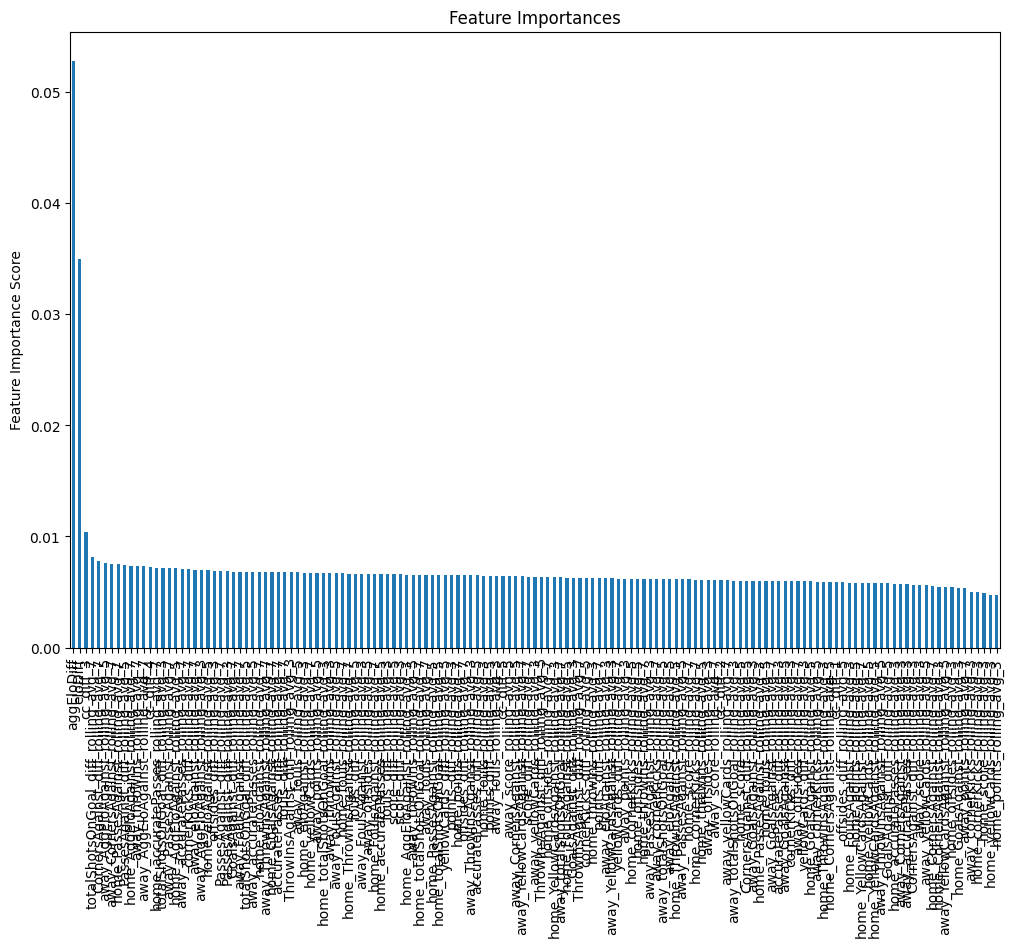

In [209]:
xgb0 = xgb.XGBClassifier(
    objective='multi:softprob',  # For multiclass classification
    num_class=3,  # Adjust based on the number of classes
    random_state=10,
    #sample_weight=sample_weights,
    use_label_encoder=False,  # To avoid warning messages
    eval_metric='auc'  # Evaluation metric for multi-class
)
modelfitx(xgb0, X_train, y_train)

In [210]:
from sklearn.model_selection import GridSearchCV


param_test1 = {
    'n_estimators': range(10, 200, 10)
}

gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        #sample_weight=sample_weights,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test1,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train, y_train)

print("Best parameters:", gsearch1.best_params_)
print("Best score:", gsearch1.best_score_)
best_n_estimators = gsearch1.best_params_['n_estimators']
param_test2 = {
    'max_depth': range(4, 15, 1),
    'min_child_weight': range(1, 10, 1)
}

gsearch2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        #sample_weight=sample_weights,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test2,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train, y_train)

print("Best parameters:", gsearch2.best_params_)
print("Best score:", gsearch2.best_score_)
best_max_depth = gsearch2.best_params_['max_depth']
best_min_child_weight = gsearch2.best_params_['min_child_weight']
param_test3 = {
    'gamma': [i/10.0 for i in range(0, 5)]
}

gsearch3 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        objective='multi:softprob',
        num_class=3,
        #sample_weight=sample_weights,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test3,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train, y_train)

print("Best parameters:", gsearch3.best_params_)
print("Best score:", gsearch3.best_score_)
best_gamma = gsearch3.best_params_['gamma']
param_test4 = {
    'subsample': [i/10.0 for i in range(2,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        #sample_weight=sample_weights,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test4,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train, y_train)

print("Best parameters:", gsearch4.best_params_)
print("Best score:", gsearch4.best_score_)
best_subsample = gsearch4.best_params_['subsample']
best_colsample_bytree = gsearch4.best_params_['colsample_bytree']
param_test5 = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.075, 0.1, 0.5]
}

gsearch5 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        objective='multi:softprob',
        num_class=3,
        #sample_weight=sample_weights,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch5.fit(X_train, y_train)

print("Best parameters:", gsearch5.best_params_)
print("Best score:", gsearch5.best_score_)
best_reg_alpha = gsearch5.best_params_['reg_alpha']
final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    #sample_weight=sample_weights,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    objective='multi:softprob',
    num_class=3,
    random_state=10,
    use_label_encoder=False,
    eval_metric='mlogloss',
    
)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    #sample_weight=sample_weights,
    verbose=True
)


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'n_estimators': 30}
Best score: 0.6465244558072051


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'max_depth': 4, 'min_child_weight': 8}
Best score: 0.6495342291771704


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'gamma': 0.1}
Best score: 0.6496317547434977


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.7, 'subsample': 0.5}
Best score: 0.6495456310419491


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'reg_alpha': 0.1}
Best score: 0.6496323779586906
[0]	validation_0-mlogloss:1.08235	validation_1-mlogloss:1.08411
[1]	validation_0-mlogloss:1.06916	validation_1-mlogloss:1.07243
[2]	validation_0-mlogloss:1.05692	validation_1-mlogloss:1.06172
[3]	validation_0-mlogloss:1.04638	validation_1-mlogloss:1.05258


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-mlogloss:1.03702	validation_1-mlogloss:1.04443
[5]	validation_0-mlogloss:1.02910	validation_1-mlogloss:1.03798
[6]	validation_0-mlogloss:1.02228	validation_1-mlogloss:1.03224
[7]	validation_0-mlogloss:1.01648	validation_1-mlogloss:1.02754
[8]	validation_0-mlogloss:1.01170	validation_1-mlogloss:1.02373
[9]	validation_0-mlogloss:1.00689	validation_1-mlogloss:1.02021
[10]	validation_0-mlogloss:1.00268	validation_1-mlogloss:1.01707
[11]	validation_0-mlogloss:0.99907	validation_1-mlogloss:1.01437
[12]	validation_0-mlogloss:0.99580	validation_1-mlogloss:1.01216
[13]	validation_0-mlogloss:0.99289	validation_1-mlogloss:1.01013
[14]	validation_0-mlogloss:0.99039	validation_1-mlogloss:1.00852
[15]	validation_0-mlogloss:0.98822	validation_1-mlogloss:1.00691
[16]	validation_0-mlogloss:0.98603	validation_1-mlogloss:1.00538
[17]	validation_0-mlogloss:0.98408	validation_1-mlogloss:1.00419
[18]	validation_0-mlogloss:0.98242	validation_1-mlogloss:1.00333
[19]	validation_0-mlogloss:0.98

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Accuracy : 0.5299
AUC Score (Train): 0.6884669178270627
CV Score : Mean - 0.5202518 | Std - 0.005875969 | Min - 0.5143176 | Max - 0.5305933


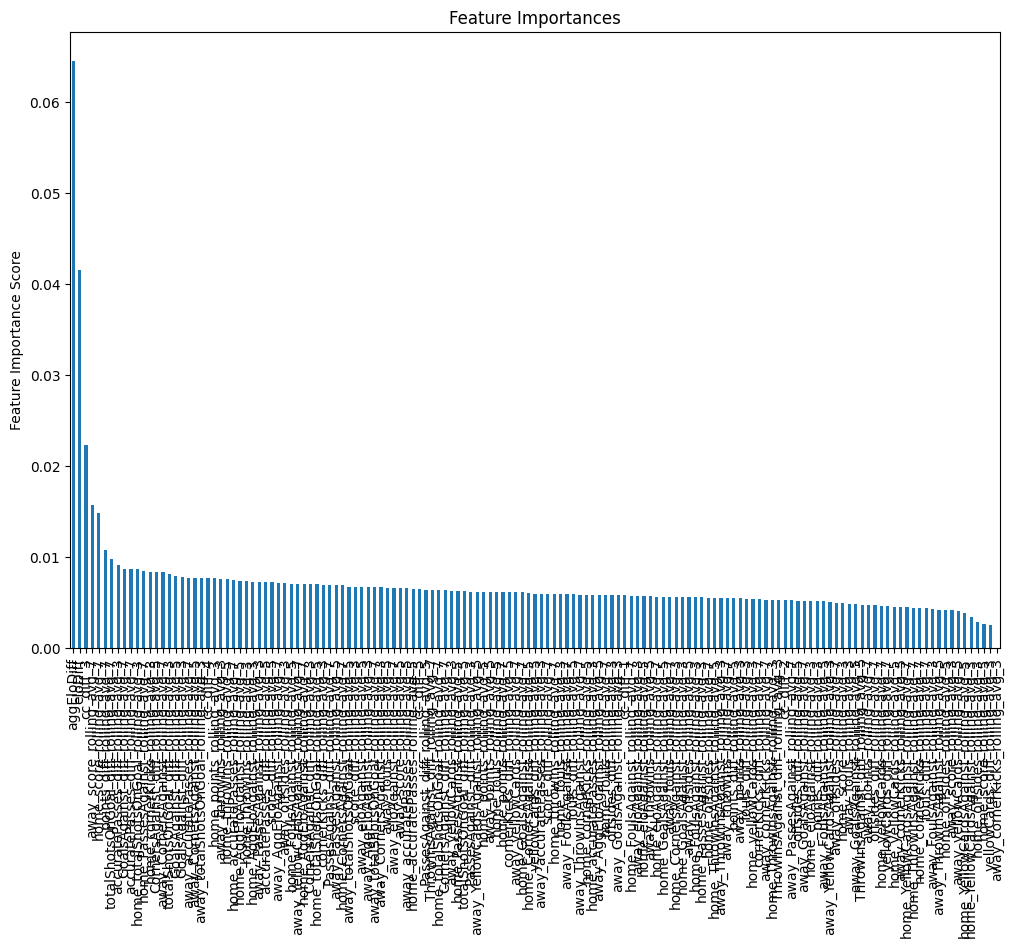

In [212]:
modelfitx(final_model,X_train,y_train)

In [192]:
from sklearn.metrics import accuracy_score

model = XGBRegressor(
    objective='reg:squarederror',  # Standard objective for regression tasks
)

modelfitx(model,features,targets)
# Predict with the model
predictions = model.predict(features)

# Map predictions to categories: 0, 1, or 2
# Using np.round() to round to the nearest integer, then cast to int
predicted_ftr = np.round(predictions).astype(int)

# Ensure the values fall within the valid range [0, 1, 2]
predicted_ftr = np.clip(predicted_ftr, 0, 2)

predicted_ftr = np.round(predictions).astype(int)
predicted_ftr = np.clip(predicted_ftr, 0, 2)  # Ensure valid FTR categories

# Calculate and print accuracy
accuracy = accuracy_score(targets, predicted_ftr)
print(f"Accuracy: {accuracy * 100:.2f}%")


Model Report


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [61]:
from sklearn.model_selection import GridSearchCV, KFold

# Define a parameter grid
param_test1 = {
    'n_estimators': range(10, 200, 10)
}

# Set up the grid search with cross-validation
gsearch1 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=10,
    ),
    param_grid=param_test1,
    scoring='neg_mean_squared_error',  # Use an appropriate scoring metric for regression
    n_jobs=-1,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)  # Use 5-fold cross-validation with shuffling
)

# Fit the grid search to the data
gsearch1.fit(X_train, y_train)

print("Best parameters:", gsearch1.best_params_)
print("Best score:", gsearch1.best_score_)


Best parameters: {'n_estimators': 20}
Best score: -0.6337974756644267


In [62]:
best_n_estimators = gsearch1.best_params_['n_estimators']


param_test2 = {
    'max_depth': range(4, 15, 1),
    'min_child_weight': range(1, 10, 1)
}

gsearch2 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=best_n_estimators,  # Use the best n_estimators from previous tuning
        objective='reg:squarederror',  # Objective function for regression
        random_state=10
    ),
    param_grid=param_test2,
    scoring='neg_mean_squared_error',  # Use an appropriate scoring metric for regression
    n_jobs=-1,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

gsearch2.fit(X_train, y_train)

print("Best parameters:", gsearch2.best_params_)
print("Best score:", gsearch2.best_score_)


Best parameters: {'max_depth': 4, 'min_child_weight': 8}
Best score: -0.6315264970433636


In [63]:
best_max_depth = gsearch2.best_params_['max_depth']
best_min_child_weight = gsearch2.best_params_['min_child_weight']

In [64]:
# Define parameter grid for gamma
param_test3 = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=10)

# GridSearchCV for XGBRegressor
gsearch3 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=best_n_estimators,  # Use the best number of estimators from previous tuning
        max_depth=best_max_depth,        # Use the best max_depth from previous tuning
        min_child_weight=best_min_child_weight,  # Use the best min_child_weight from previous tuning
        objective='reg:squarederror',    # Regression objective
        random_state=10
    ),
    param_grid=param_test3,
    scoring='neg_mean_squared_error',    # Use an appropriate regression scoring metric
    n_jobs=-1,
    cv=kf                                # Use KFold cross-validation
)

# Fit the grid search to the data
gsearch3.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", gsearch3.best_params_)
print("Best score:", gsearch3.best_score_)


Best parameters: {'gamma': 0.0}
Best score: -0.63095904809535


In [65]:
best_gamma = gsearch3.best_params_['gamma']


In [66]:
# Define parameter grid for subsample and colsample_bytree
param_test4 = {
    'subsample': [i / 10.0 for i in range(2, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=10)

# GridSearchCV for XGBRegressor
gsearch4 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=best_n_estimators,  # Use the best number of estimators from previous tuning
        max_depth=best_max_depth,        # Use the best max_depth from previous tuning
        min_child_weight=best_min_child_weight,  # Use the best min_child_weight from previous tuning
        gamma=best_gamma,                # Use the best gamma from previous tuning
        objective='reg:squarederror',    # Regression objective
        random_state=10
    ),
    param_grid=param_test4,
    scoring='neg_mean_squared_error',    # Use an appropriate regression scoring metric
    n_jobs=-1,
    cv=kf                                # Use KFold cross-validation
)

# Fit the grid search to the data
gsearch4.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", gsearch4.best_params_)
print("Best score:", gsearch4.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score: -0.6306847517631222


In [67]:
best_subsample = gsearch4.best_params_['subsample']
best_colsample_bytree = gsearch4.best_params_['colsample_bytree']


In [68]:

# Define parameter grid for reg_alpha
param_test5 = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=10)

# GridSearchCV for XGBRegressor
gsearch5 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=best_n_estimators,       # Use the best number of estimators from previous tuning
        max_depth=best_max_depth,             # Use the best max_depth from previous tuning
        min_child_weight=best_min_child_weight,  # Use the best min_child_weight from previous tuning
        gamma=best_gamma,                     # Use the best gamma from previous tuning
        subsample=best_subsample,             # Use the best subsample from previous tuning
        colsample_bytree=best_colsample_bytree,  # Use the best colsample_bytree from previous tuning
        objective='reg:squarederror',         # Regression objective
        random_state=10
    ),
    param_grid=param_test5,
    scoring='neg_mean_squared_error',         # Use an appropriate regression scoring metric
    n_jobs=-1,
    cv=kf                                      # Use KFold cross-validation
)

# Fit the grid search to the data
gsearch5.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", gsearch5.best_params_)
print("Best score:", gsearch5.best_score_)


Best parameters: {'reg_alpha': 0.001}
Best score: -0.6306847262349079


In [69]:
best_reg_alpha = gsearch5.best_params_['reg_alpha']


In [70]:
# Define the final model
final_model = XGBRegressor(
    learning_rate=0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    objective='reg:squarederror',  # Regression objective
    random_state=10
)

# Fit the final model
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation on both train and test sets
    verbose=True
)



[0]	validation_0-rmse:0.80932	validation_1-rmse:0.81225
[1]	validation_0-rmse:0.80679	validation_1-rmse:0.81001
[2]	validation_0-rmse:0.80380	validation_1-rmse:0.80727
[3]	validation_0-rmse:0.80131	validation_1-rmse:0.80513
[4]	validation_0-rmse:0.79922	validation_1-rmse:0.80323
[5]	validation_0-rmse:0.79751	validation_1-rmse:0.80166
[6]	validation_0-rmse:0.79602	validation_1-rmse:0.80052
[7]	validation_0-rmse:0.79480	validation_1-rmse:0.79949
[8]	validation_0-rmse:0.79371	validation_1-rmse:0.79870
[9]	validation_0-rmse:0.79276	validation_1-rmse:0.79793
[10]	validation_0-rmse:0.79196	validation_1-rmse:0.79740
[11]	validation_0-rmse:0.79126	validation_1-rmse:0.79703
[12]	validation_0-rmse:0.79062	validation_1-rmse:0.79667
[13]	validation_0-rmse:0.79011	validation_1-rmse:0.79637
[14]	validation_0-rmse:0.78962	validation_1-rmse:0.79613
[15]	validation_0-rmse:0.78908	validation_1-rmse:0.79599
[16]	validation_0-rmse:0.78864	validation_1-rmse:0.79583
[17]	validation_0-rmse:0.78826	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)


Model Report
Mean Squared Error : 0.6204
Mean Absolute Error : 0.6698
CV Score : Mean - 0.6314 | Std - 0.005895 | Min - 0.6234 | Max - 0.6393


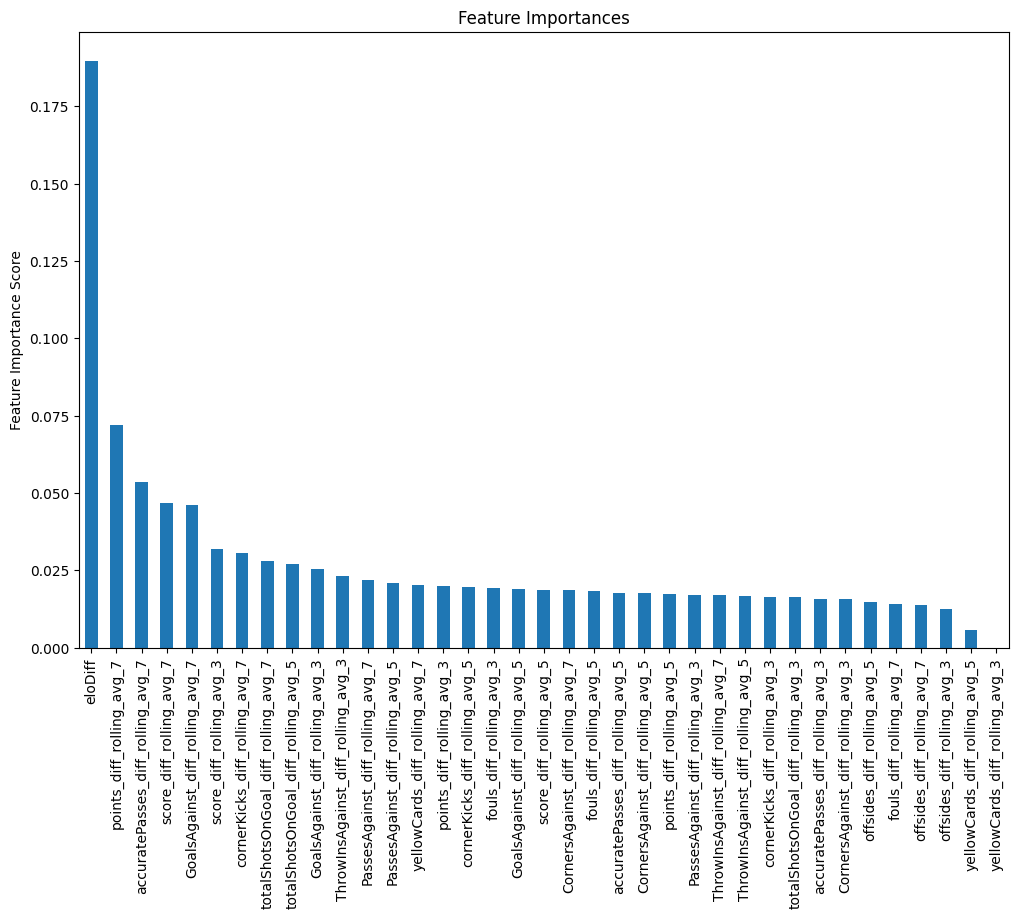

Accuracy: 35.10%


In [71]:
modelfitx(final_model,X_train,y_train)
predictions = final_model.predict(features)

# Map predictions to categories: 0, 1, or 2
# Using np.round() to round to the nearest integer, then cast to int
predicted_ftr = np.round(predictions).astype(int)
predicted_ftr = np.clip(predicted_ftr, 0, 2)  # Ensure valid FTR categories

# Calculate and print accuracy
accuracy = accuracy_score(targets, predicted_ftr)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [72]:
# Assuming your model is named xgb_model
import pandas as pd

# Get feature importances
importances = final_model.feature_importances_
print(len(importances))
print(len(X_train.columns))

# Create a DataFrame to display alongside feature names
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Replace X.columns with the feature names if using numpy arrays
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)
feature_importances.to_csv('possion_importancces.csv',index=False)

37
37
                                Feature  Importance
36                              eloDiff    0.189593
3             points_diff_rolling_avg_7    0.072117
6     accuratePasses_diff_rolling_avg_7    0.053520
0              score_diff_rolling_avg_7    0.046807
15      GoalsAgainst_diff_rolling_avg_7    0.046058
2              score_diff_rolling_avg_3    0.031976
18       cornerKicks_diff_rolling_avg_7    0.030597
9   totalShotsOnGoal_diff_rolling_avg_7    0.028123
10  totalShotsOnGoal_diff_rolling_avg_5    0.027105
17      GoalsAgainst_diff_rolling_avg_3    0.025309
14   ThrowInsAgainst_diff_rolling_avg_3    0.023170
30     PassesAgainst_diff_rolling_avg_7    0.021939
31     PassesAgainst_diff_rolling_avg_5    0.020774
27       yellowCards_diff_rolling_avg_7    0.020222
5             points_diff_rolling_avg_3    0.019939
19       cornerKicks_diff_rolling_avg_5    0.019627
26             fouls_diff_rolling_avg_3    0.019446
16      GoalsAgainst_diff_rolling_avg_5    0.019017
1     

In [73]:
from sklearn.linear_model import LinearRegression


# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Model coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Mean Squared Error (MSE): 0.6334548093607791
Mean Absolute Error (MAE): 0.6834871330861163
Root Mean Squared Error (RMSE): 0.7958987431581854
Intercept: 0.7925479976336555
Coefficients: [-2.04179131e-02  8.73046982e-03 -8.21382934e-03 -5.60328666e-03
  9.02133362e-03  5.63762826e-03 -7.67193745e-04  2.01108700e-04
  9.15249677e-05 -8.56083169e-03 -1.26422833e-03 -1.28937688e-03
  1.17474575e-03  2.33451431e-03 -3.31547121e-03  4.00193964e-03
  2.52099638e-02  4.55875423e-04 -9.12600301e-03 -6.92707546e-03
  7.73391998e-03 -6.05200624e-03  5.08555664e-03  7.95913835e-03
 -2.33996272e-03  1.72176779e-04 -8.65629167e-04 -2.39376998e-03
  2.10130653e-03  9.19215981e-04 -2.39354966e-04  2.41320236e-04
  1.21374534e-04  8.67261461e-03 -5.06923286e-03  1.66609389e-03
 -4.18413826e-04]


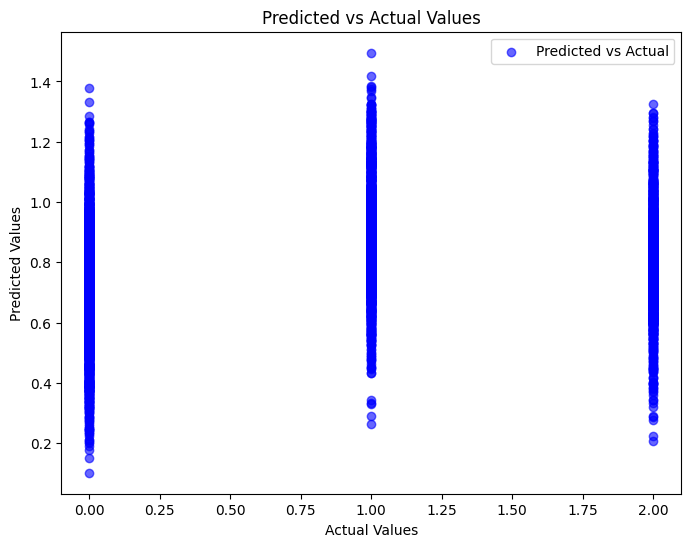

In [74]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()


In [75]:

y_pred.mean()

0.7988052547547266

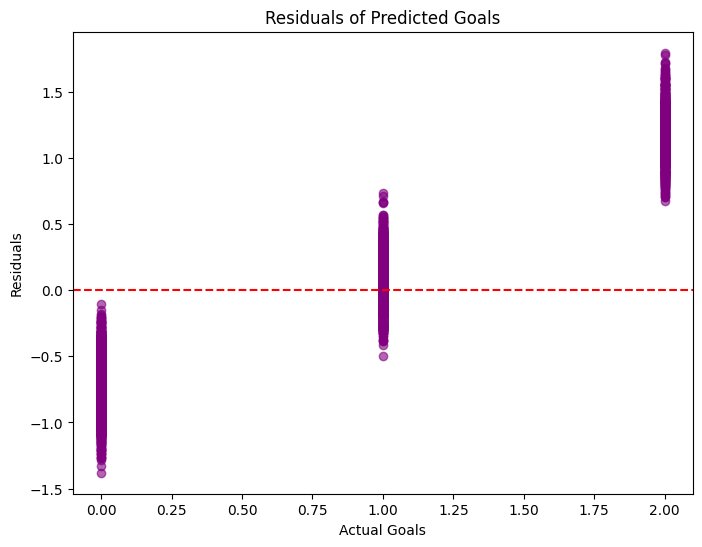

In [76]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel('Actual Goals')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted Goals')
plt.show()


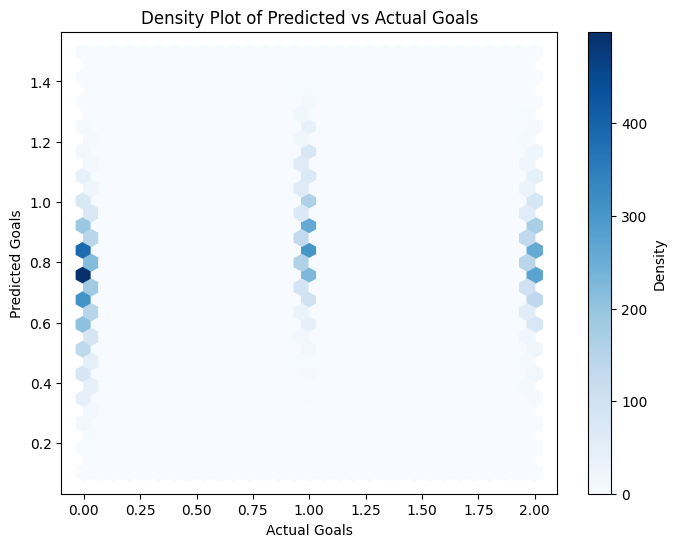

In [77]:
plt.figure(figsize=(8, 6))
plt.hexbin(y_test, y_pred, gridsize=30, cmap='Blues')
plt.colorbar(label='Density')

plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Density Plot of Predicted vs Actual Goals')
plt.show()


In [78]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual Goals': y_test, 'Predicted Goals': y_pred})

# Display the DataFrame
print(results_df)

results_df.to_csv('poisson.csv',index=False)


       Actual Goals  Predicted Goals
926               2         0.794393
22954             1         1.040660
14351             2         0.752031
2929              2         0.815393
25252             2         0.858169
...             ...              ...
26277             0         0.948988
23436             1         0.852694
5821              0         0.612346
8293              0         0.822408
3548              0         0.857514

[6707 rows x 2 columns]


In [466]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate training error
train_predictions = final_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)

# Calculate validation error
val_predictions = final_model.predict(X_test)
val_mse = mean_squared_error(y_test, val_predictions)
val_mae = mean_absolute_error(y_test, val_predictions)

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")
print(f"Training MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")


Training MSE: 2.604727161526901
Validation MSE: 2.6610427887110313
Training MAE: 1.2929948967900768
Validation MAE: 1.3088946342646


In [ ]:
features = merged_df.drop(columns=['totalGoals','hometeam','awayteam','homescore','awayscore','homeElo','awayElo','index'])
targets = merged_df['totalGoals']


In [467]:
import statsmodels.api as sm

# Assuming X_train and y_train are your training data
# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)

# Fit the Poisson regression model
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Print the model summary to see coefficients and fit statistics
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             totalGoals   No. Observations:                26825
Model:                            GLM   Df Residuals:                    26790
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50276.
Date:                Mon, 28 Oct 2024   Deviance:                       29651.
Time:                        20:49:32   Pearson chi2:                 2.65e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02868
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [381]:
# Add a constant to the test data as well
X_test = sm.add_constant(X_test)

# Get predicted goals
y_pred_poisson = poisson_model.predict(X_test)

# Convert to integers if needed
y_pred_poisson = y_pred_poisson.round()


In [382]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_poisson)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 1.2955121514835246


In [383]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_poisson)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.771880125242284


In [384]:
rmse = mean_squared_error(y_test, y_pred_poisson, squared=False)
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 1.664896430785496


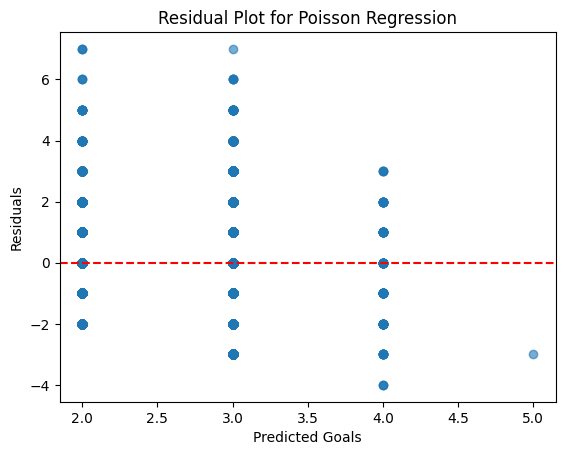

In [385]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_poisson
plt.scatter(y_pred_poisson, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Goals')
plt.ylabel('Residuals')
plt.title('Residual Plot for Poisson Regression')
plt.show()


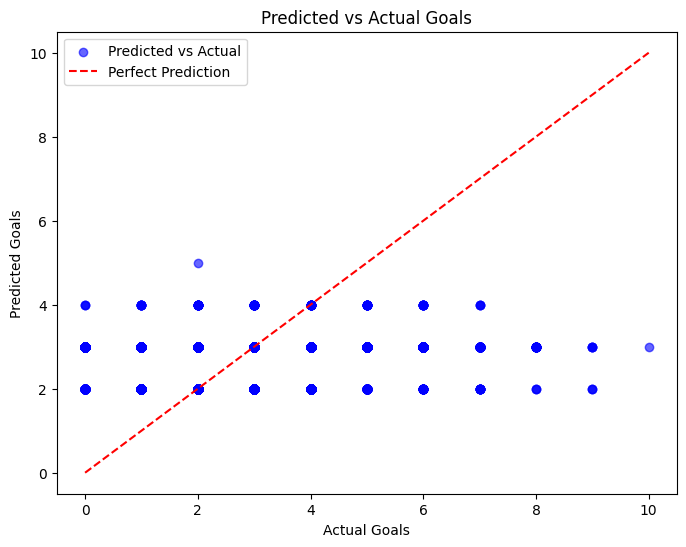

In [386]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poisson, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Predicted vs Actual Goals')
plt.legend()
plt.show()


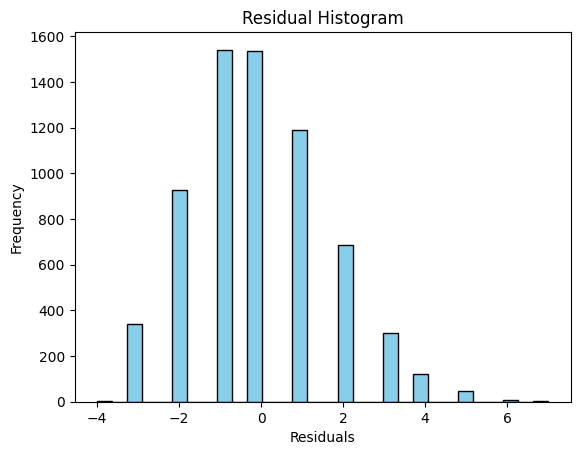

In [387]:
residuals = y_test - y_pred_poisson
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()


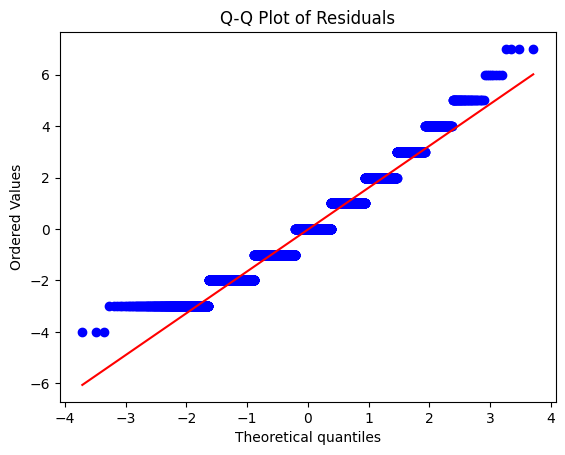

In [388]:
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


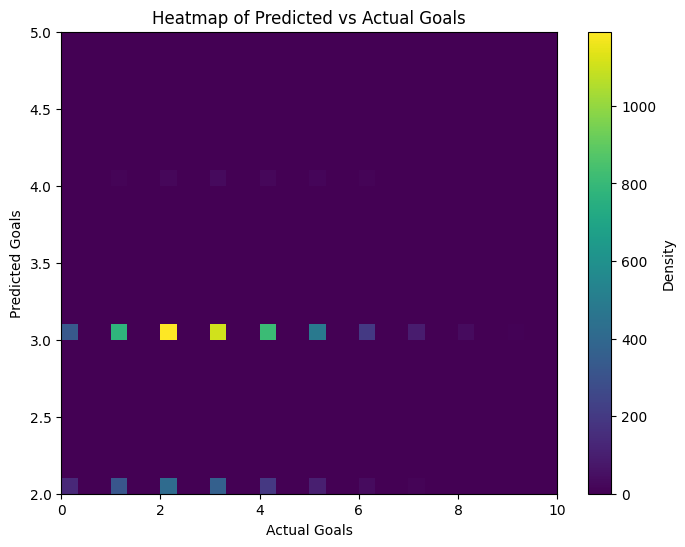

In [398]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred_poisson are your actual and predicted values
plt.figure(figsize=(8, 6))

# Use a 2D histogram to bin predicted vs. actual values
plt.hist2d(y_test, y_pred_poisson, bins=30, cmap='viridis')  # You can adjust 'bins' and 'cmap' as needed

# Add color bar
plt.colorbar(label='Density')

# Labels and title
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Heatmap of Predicted vs Actual Goals')

plt.show()


In [399]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual Goals': y_test, 'Predicted Goals': y_pred_poisson})

# Display the DataFrame
print(results_df)

results_df.to_csv('poisson.csv',index=False)



       Actual Goals  Predicted Goals
926               0              3.0
22954             2              2.0
14351             0              3.0
2929              2              3.0
25252             2              2.0
...             ...              ...
26277             4              2.0
23436             2              2.0
5821              1              3.0
8293              1              2.0
3548              1              3.0

[6707 rows x 2 columns]


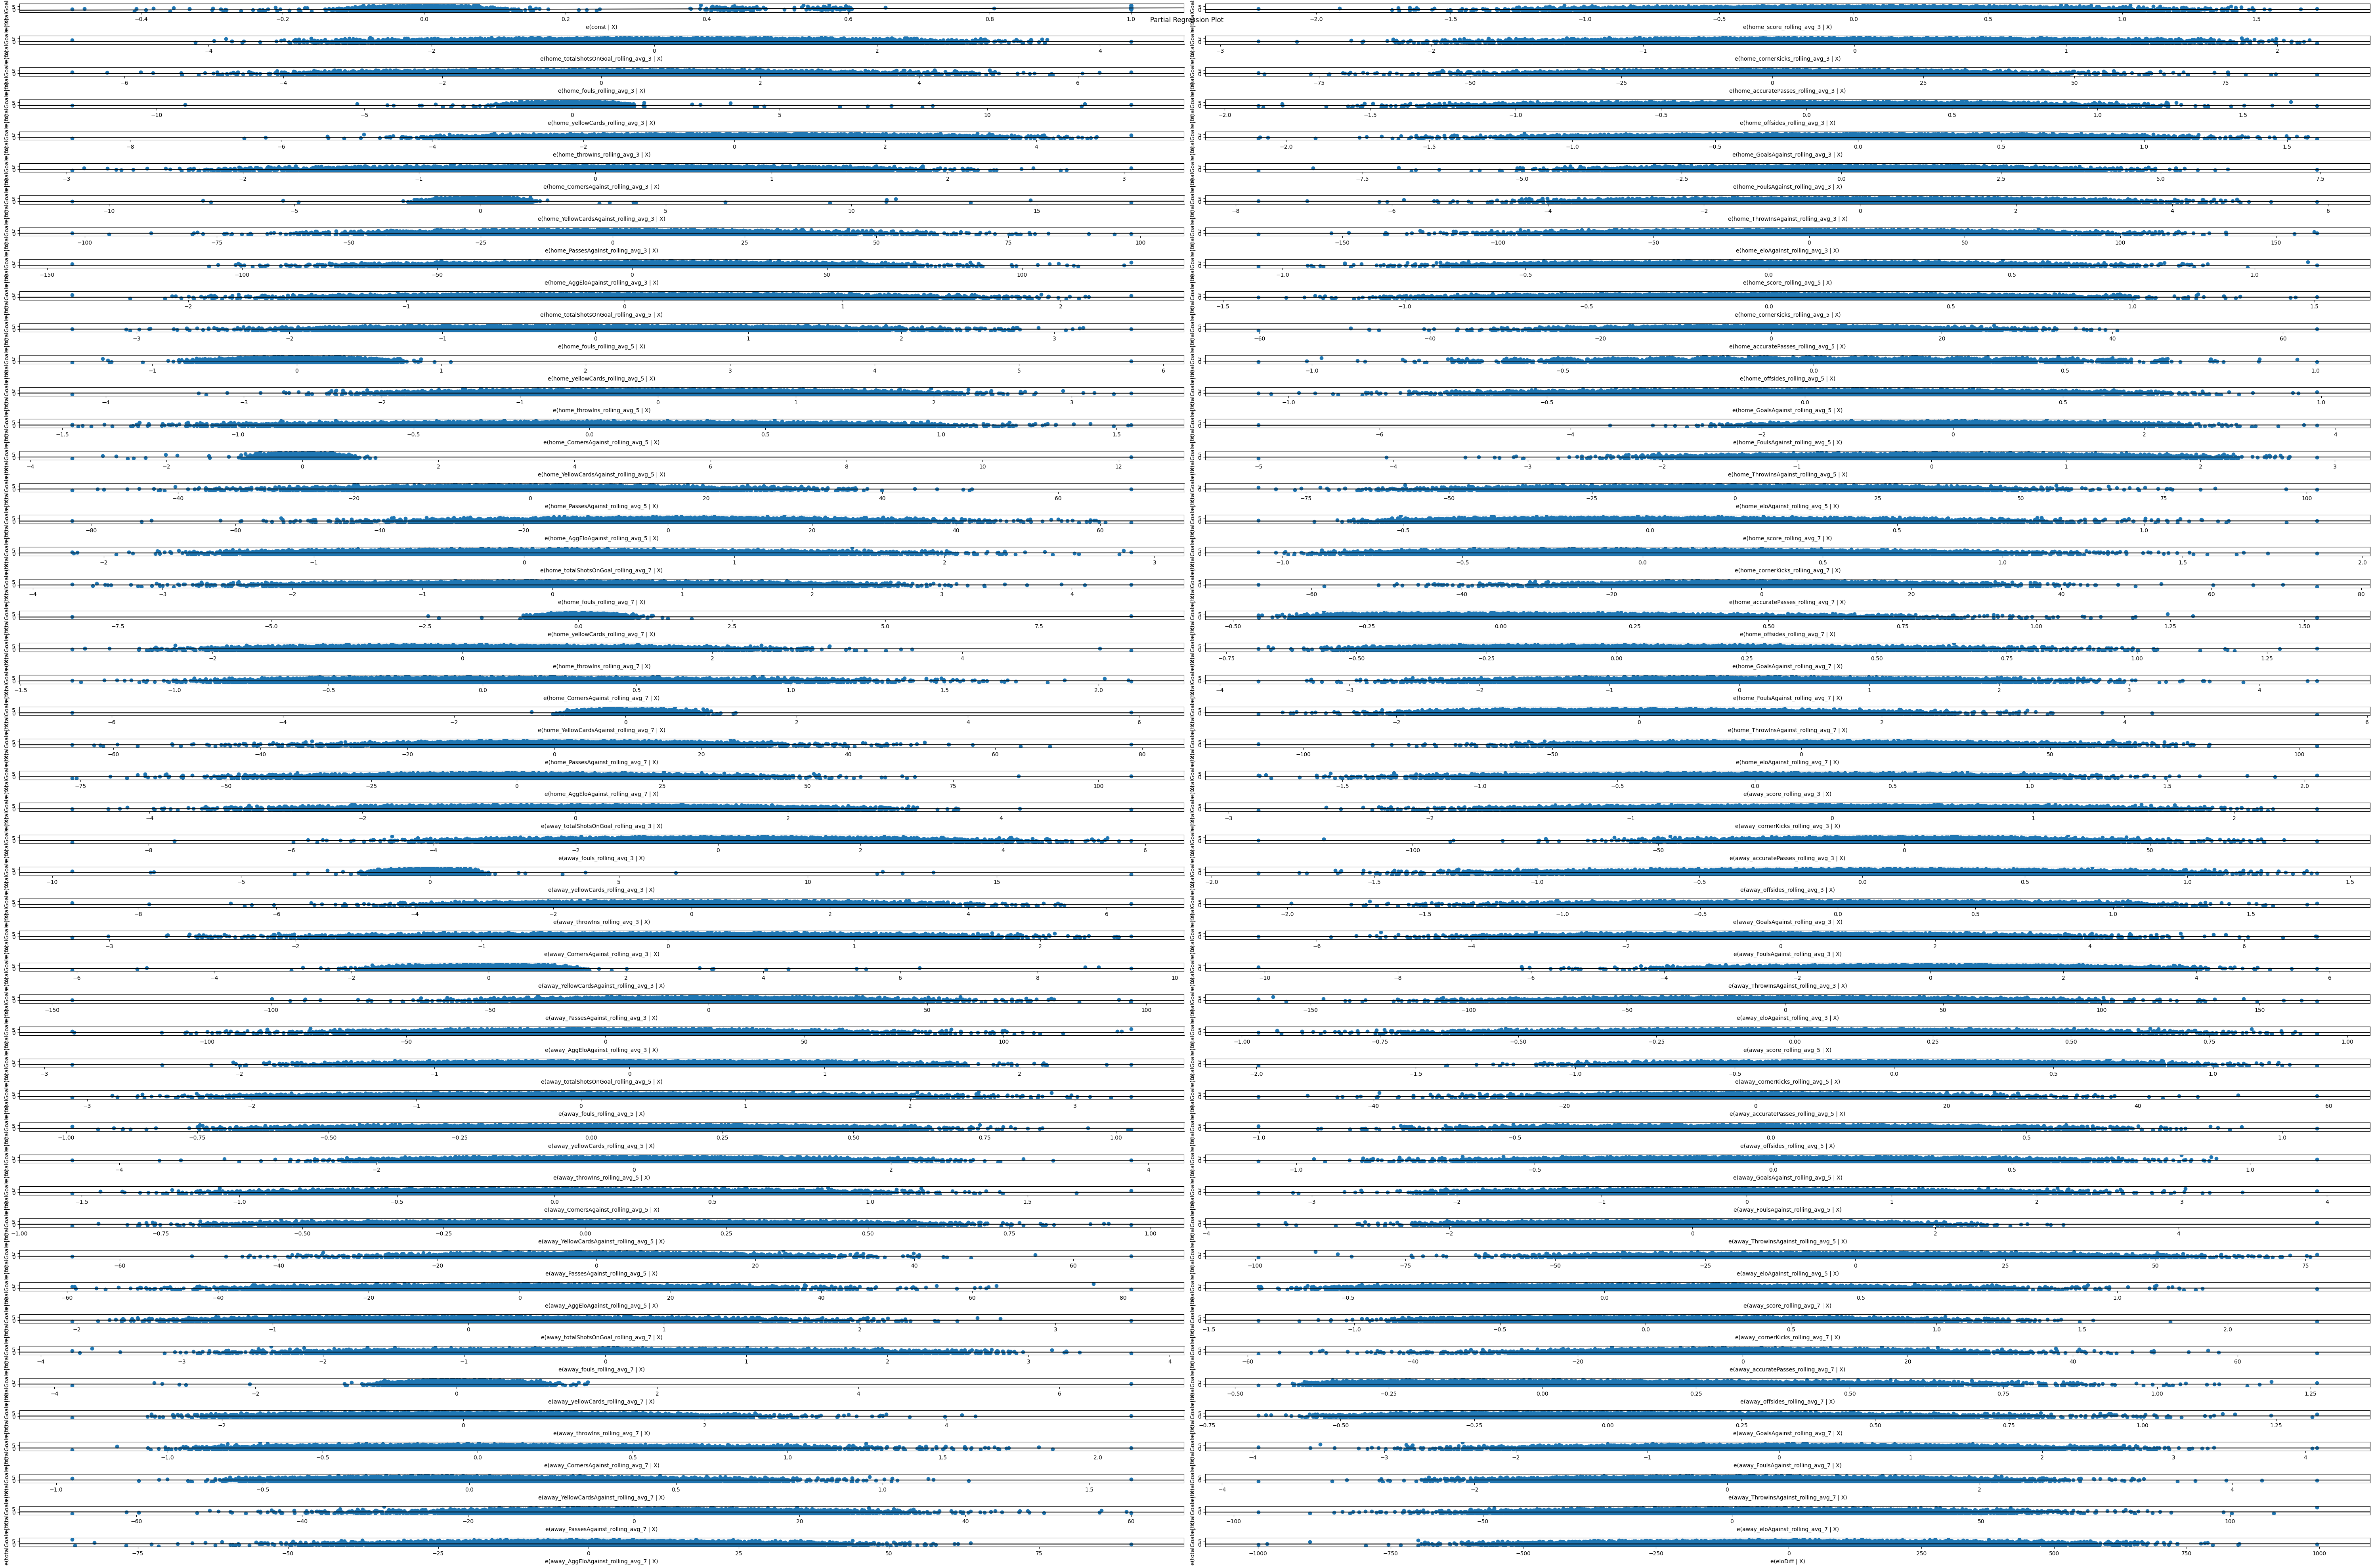

In [396]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a figure with a specified size
fig = plt.figure(figsize=(60, 40))

# Generate the partial regression grid plot
sm.graphics.plot_partregress_grid(poisson_model, fig=fig)

plt.tight_layout()
plt.show()


In [397]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(poisson_model)
cooks_d = influence.cooks_distance[0]

plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.show()


AttributeError: 'GLMResults' object has no attribute 'resid'